<a href="https://colab.research.google.com/github/mjvakili/MLcourse/blob/master/windowed_polyfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Let's start by importing the libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [0]:
#Downloading the data from statsmodels library (the same dataset that we worked with in data exploration)
from statsmodels.datasets import co2
data = co2.load_pandas().data
#changing the date units to julian date
t = 2000 + (np.array(data.index.to_julian_date()) - 2451545.0) / 365.25
y = np.array(data.co2)
#Drop the NaNs for now! Note that you can also use backward fill or forwardfill functionalities in panda
m = np.isfinite(t) & np.isfinite(y)
#The data with dropped missing values!
t, y = t[m], y[m]

In order to analyze this time series, we generate a windowed dataset:
We use a sliding window of a specified length to divide the data into partitions of equal size. We treat these windowed datasets as the inputs and the immediate value of the time series after each window as the output. 

Let's imagine that the window size is 4, then the list of inputs are:

$X = \{(x_1, x_2, x_3, x_4), (x_2, x_3, x_4, x_5), ... \}$ while the list of outputs are $Y= \{x_5, x_6, ....\}$. In other words, we use the values in the past in order to make prediction about the values in the future. 

Therfore, the problem of forecasting can be solved by finding the mapping between every four adjecent time-series values and the value that comes immediately after them:

$(x_1, x_2, x_3, x_4) \rightarrow x_5$

$(x_2, x_3, x_4, x_5) \rightarrow x_6$

$(x_3, x_4, x_5, x_6) \rightarrow x_7$

$.$

$.$

$.$

$(x_{N-4}, x_{N-3},x_{N-2}, x_{N-1}) \rightarrow x_N$

In [0]:
def create_windowed_series(series, window_size = 1):
  '''
  This function takes the series as input, 
  and it returns the windowed dataset as discussed above
  ''' 
  data_x, data_y = [], []
  for i in range(len(series) - window_size-1):
    x_value = series[i: i+window_size, 0]
    y_value = series[i+window_size, 0]
    data_x.append(x_value)
    data_y.append(y_value)
    
  return np.array(data_x), np.array(data_y)

def create_windowed_time(time, window_size = 1):
  '''
  This function takes the times as input, 
  and it returns the windowed times. 
  P.S. This is only useful for visualization of the results
  and we do not need it for the modeling
  '''  
  data_x, data_y = [], []
  for i in range(len(time) - window_size-1):
    x_value = time[i: i+window_size]
    y_value = time[i+window_size]
    data_x.append(x_value)
    data_y.append(y_value)
    
  return np.array(data_x), np.array(data_y)

def preprocess(t, x, train_ratio):
    '''
     scales the windowed data 
    '''
    x = x[:, np.newaxis]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_x = scaler.fit_transform(x)
    train_size = int(len(scaled_x) * train_ratio)
    train_y, test_y = scaled_x[0:train_size], scaled_x[train_size:]
    train_time, test_time = t[0:train_size], t[train_size:]
    
    preprocessed = {"transform" : scaler, 
                   "train_time" : train_time, 
                   "test_time" : test_time, 
                   "train_y" : train_y, 
                   "test_y" : test_y}
    
    return preprocessed


In [0]:
preprocessed = preprocess(t, y, train_ratio=0.8)

In [0]:
trainX, trainY = create_windowed_series(preprocessed['train_y'], window_size = 60)
testX, testY = create_windowed_series(preprocessed['test_y'], window_size = 60)

_, train_target_t= create_windowed_time(preprocessed['train_time'], window_size = 60)
_, test_target_t = create_windowed_time(preprocessed['test_time'], window_size = 60)
 
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1])
testX = testX.reshape(testX.shape[0], testX.shape[1])

Now that we have preprocessed the training and the test windowed datasets, we can move on to modeling the mapping between the windowed inputs and the outputs.

We use the `Pipeline` functionality of `sklearn` to follow these steps in a pipeline: 

First we scale the data using the `MinMaxScaler`.
Then we create second order Polynomial features with the inputs.
Then we apply the ridge regression. Note that Ridge regression is similar to linear regression with the difference that there is an additional regularization term: $ \sim \alpha x^{2}$ added to the cost function. This prevents the polynomial coefficients to become large in the optimization process and it avoids overfitting. 

Note that the regularization parameter $\alpha$ is now a hyperparameter and therfore we need to find its value using $k-$fold cross validation (for a reminder of the cross-validation, please refer to the first lecture).  

In [14]:
fitting_pipeline = make_pipeline(MinMaxScaler(), PolynomialFeatures(2), Ridge())
param_grid = {'ridge__alpha': np.logspace(-5, 5, 20)}
grid = GridSearchCV(fitting_pipeline, param_grid, cv=5)
grid.fit(trainX, trainY)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('minmaxscaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state...
             para

In [15]:
grid.fit(trainX, trainY)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('minmaxscaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state...
             para

In [0]:
train_predict = grid.predict(trainX)
test_predict = grid.predict(testX)

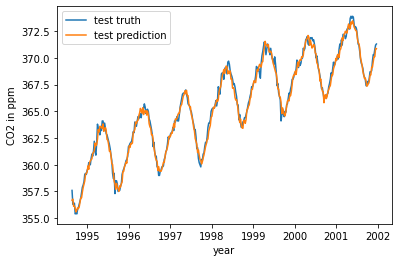

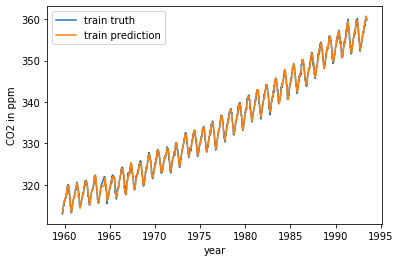

In [19]:
transform = preprocessed['transform']
inverse = transform.inverse_transform
plt.plot(test_target_t, inverse(testY[:, np.newaxis]))
plt.plot(test_target_t, inverse(test_predict[:, np.newaxis]))
plt.xlabel("year")
plt.ylabel("CO2 in ppm")
plt.legend(['test truth', 'test prediction'])
plt.show()
plt.close()

plt.plot(train_target_t, inverse(trainY[:, np.newaxis]))
plt.plot(train_target_t, inverse(train_predict[:, np.newaxis]))
plt.xlabel("year")
plt.ylabel("CO2 in ppm")
plt.legend(['train truth', 'train prediction'])
plt.show()
plt.close()

As evident in the upper panel of the plots above, there is an excellent agreement between the predicted values of the CO2 concentrations in the test time series and the true values.